<h2>Mining Delpher Data</h2>
<h3>Harvest, Clean and Analyse Large Amounts of Digitised Text</h3>

<p>When analysing sources of the National Library of the Netherlands (KB), researchers often use Delpher, the online gateway to more than 10 million pages of historical text (newspapers, books,journals & radio bulletins), mostly in Dutch. Delpher allows you to search and browse all documents in full text, making it a good resource for close reading. However, when you want to analyse large amounts of data to do distant reading, the KB allows researchers access to both the digital images, metadata, and full text in bulk via KB’s Dataservices & API’s, as well as additional data such as the Medieval Illuminated Manuscripts and the Dutch Digital Parliamentary Papers. </p>

<p>To successfully harvest this data and subsequently clean and analyse it, you need knowledge about:

<ul>
<li> the KB’s data formats and infrastructure</li>
<li> tools to clean the data and subsequently</li>
<li> tools to analyse the data.</li>
</ul>
</p>


<h3>Jupyter Notebook Tips</h3>
<ul>
<li>New cells are created with the <b>Plus</b> button in the toolbar. When not editing, this can be done by pressing ‘b’ on your keyboard.</li>
<li>New cells are “code” cells by default, but can be changed to “Markdown” (a type of text input) in a dropdown menu on the toolbar. In edit mode, you can paste in code from this lesson or type it yourself.</li>
<li>Switching a cell to edit mode is done by pressing Enter.</li>
<li>Running a cell is done by clicking Play in the toolbar, or with Shift + Enter.</li>
<li>We use two types of cells: Markdown (for text) and Code (for code blocks)


<h3>Libraries and settings</h3>

In [5]:
import csv #to work with csv files
import pandas as pd #for data analysis
import numpy as np #for scientific computing
import requests #for html requests 
from lxml import etree #for browsing xml structures

SRU_BASE_URL = 'http://jsru.kb.nl/sru/sru?' #the url for the KB's sru service
MAX_RECORDS = 1000 #the number of records queried at a time 
pd.set_option('display.max_colwidth', -1) #this option show the full cell contents of the pandas output. 
#this option shows graphs within Jupyter
%matplotlib inline

<h2>Harvest Function</h2>

The following function is used to communicate with the SRU service, download collection of texts with the fields 'text', 'date', and 'title'. The download is stored as a tsv file. 

In [3]:
def jsru_query(collection, cql, filename):
    '''
    Query jSRU to obtain from collection context (text), date and title fields,
    write results to tab separated CSV file.
    '''

    start_record = 1

    request_payload = {
        'operation': 'searchRetrieve',
        'x-collection': collection,
        'x-fields': 'content',
        'maximumRecords': MAX_RECORDS,
        'startRecord': start_record,
        'query': cql
    }

    sru_response = requests.get(SRU_BASE_URL, params=request_payload)
    sru_tree = etree.fromstring(sru_response.content)

    num_records = sru_tree.find('{http://www.loc.gov/zing/srw/}numberOfRecords')
    num_records = int(num_records.text)
    
    csv_writer = csv.writer(open(filename, 'w', newline=''), delimiter='\t', )
    csv_writer.writerow(['title', 'date', 'text'])

    records_left = (num_records >= 1)
    while records_left:
        
        for record in sru_tree.iter('{http://www.loc.gov/zing/srw/}recordData'):
            title = record.find('{http://purl.org/dc/elements/1.1/}title').text
            date = record.find('{http://purl.org/dc/elements/1.1/}date').text
            text = record.find('content').text

            csv_writer.writerow([title, date, text])

        records_left=(start_record + MAX_RECORDS <= num_records)
        if records_left:
            start_record = start_record + MAX_RECORDS
            request_payload['startRecord'] = start_record
            sru_response = requests.get(SRU_BASE_URL, params=request_payload)
            sru_tree = etree.fromstring(sru_response.content)

<h2>Downloading data from Delpher</h2>

<p>Here you can run the function called jsru_query that is defined in the cell above. This function has three parameters.</p> 
<ol>
<li>the collection (ANP)</li>
<li>the query ("verenigde staten" and nederland not duitsland and date within "01-01-1971 31-12-1979"), and 
<li>the name of the output file (output.tsv).</li>
</ol>

Make sure to enclose these three parameters with apostrophes. 
We will now try to rebuild the queries we made during the first part of this workshop.

In [18]:
#Example Query
jsru_query('ANP', 
           'klimaat and date within "01-01-1939 31-12-1984"', 
           'query_klimaat.tsv')

<h2>Importing downloaded data into Python</h2>
<p>Now we will load the tsv into python using a library called Pandas. <br> Pandas is a library that is often used by data scientists. <br> You can read more about Pandas here: https://pandas.pydata.org
<br> N.B. A table or spreadsheet is called a dataframe in Pandas. </p>
You can find a new cheat sheet here: https://www.dataquest.io/blog/images/cheat-sheets/pandas-cheat-sheet.pdf

In [19]:
#define the name of your file here as your input here. This should be the same as the name of 
#the output you defined in the query function
#delimiter indicates how the file is separated. Tabs = '\t', and commas = ','.
#df is the default name for a dataframe. You can give this variable any name you prefer. 
df = pd.read_csv('query_klimaat.tsv', delimiter='\t', encoding = "ISO-8859-1") 

In [12]:
#this command shows you the first lines of the file. Put a number between the parenthesis to specify and exact number.
#Change df.head into df.tail to see what happens
df.tail(25) 

,title,date,text
9,ANP Nieuwsbericht - 04-05-1977 - 113,1977/05/04 00:00:00,"\n Red.: \n Datum: \n Tijd: \n Onderwerp: \n Haz,.. \n 4 5 77 \n 18-18^ \n Omzet Gasunie \n 15. \n De Nederlandse Gasunie verwacht dat haar omzet dit jaar met \n ongeveer 20 proce^nt zal stijgen tot bijna 14 miljard gulden \n 3. \n De Unie schrijft die stijging voor een deel toe aan de gro- \n 4. \n / ^ tere leveringen van aas/ vooral im eigen land,' L V \n voor een \n 5. \n ander deel aan prijsverhogingen. Het afgelopen jaar 1976 \n is de afzet achtergebleven bij de verwachtingen. Dit als \n 7. \n gevolg van het zachte weer, het voortduren van het slechte \n 8. \n economische klimaat en activiteiten ter besparing van energi&lt; \n 9. \n De Gasunie beklaagt er zich in haar verslag over, dat/ondanks \n 10. \n een verhoging op 1 januari vorig jaar) de gasprijs voor \n 11. \n kleinverbruikers nog steeds onvoldoende is aangepast aan het \n 12. \n internationale prijspeil. De Nederlandse Gasunie heeft in \n 13. \n 14 \n 1976 ruim 80 miljoen gulden netto-winst geboekt - iets meer \n dan een jaar ervoor. - \n Bron: gnp \n Regels: 13^ \n\n"
10,ANP Nieuwsbericht - 24-05-1978 - 1,1978/05/24 00:00:00,"\n . *! \n Red.: Datum: \n swaab 24. 5. 78 \n Tijd: \n g. o \n Onderwerp: \n enkele punten \n Ruim duizend Belgische parachutisten zijn uit Zaire in hun \n land teruggekeerd. ------- \n In ItaliÃ« ligt het treinverkeer stil als gevolg van een \n 24-uurs-staking bij de spoorwegen. ---- \n 5 \n 6. \n \Peru, In&lt; Ã«^B9^nebben de vakbonden de stakende arbeiders opgeroepen \n 8. \n weer aan het werk te gaan. ----- \n 10. \n Het industriÃ«le klimaat in de meeste EEG-landen is in de / drie J eerstejmaanden van dit jaat verbeterd. \n (^J-yV y \n 11. \n 12. \n 13. \n 14. \n 15 \n het weer ! op de meeste plaatsen droog met veel bewolking. r rlnngn f*n knit a^ Â°^ ****** ^^^ m-ic+- ^=. r&lt; ^^o maxima van 12 graden aan zee tot 16 graden in het binnenland. \n &amp; R- \n Bron: \n Regels \n\n"
11,ANP Nieuwsbericht - 23-03-1971 - 53,1971/03/23 00:00:00,"\n Red. \n Datum: \n Tijd: \n Onderwerp: \n Gin.. \n 23-3-71. 1. 2. ^-13 sowjetkarnexplnsie \n 2. \n 7. \n 10. \n 11. \n 12. \n 13. \n 14. \n 15. \n In de Sowjetunie heeft zich vanochtend weer een krachtige ondergrondse kernontploffing voorgedaan, dit keer vermoedelijk- op de westelijke hellingen van het Oeral-gebergte. De explosie was nog zwaarder dan die van gisterochtend bij Semipalatinsk in het aziatische deel van de Sowjetunieg De kracht dAa*rvan werd geschat op 1 Megaton. Volgens het seismologisch instituut in Uppsala, Zweden, ging het gisteren- om een militaire proef. De ontploffing van vanochten zou teweeg gebracht zijn voor vreedzame doeleinden. Weate- /de/ lijke deskundigen nemen al enige tijd aan dat/russen met behulp- van ondergrondse kernontploffingen rivieren willen verleggen naar het noorden. Doel ervan zou zijn het klimaat in noordelijker delen van de Sowjetunie te verbeteren. - \n 650. 1. 18. 50. 000. 10. 70. vdm. \n Bron: ap-Upi \n Regets: -j ^ \n\n"
12,ANP Nieuwsbericht - 16-08-1971 - 1,1971/08/16 00:00:00,"\n Red.: \n jansen \n Datu \n m: \n 16-8-71 \n Tijd: 23. 55 \n Onderwerp: Mon. toestand \n 2. \n 4. \n 5. \n 7. \n 8. \n 10. \n 11. \n 12. \n 13. \n 14. \n 15. \n 650. 1. 17. 50. 000. 3. 70. vdM. \n Als gevolg van de economische maatregelen van president \n Nixon zijn vandaag op de New Yorkse effectenbeurs \n records gebroken. Er werden ruim 31, 7-miljoen aandelen \n verhandeld; het vorige record was ruim 28, 2-miljoen. \n Het Dow Jones-gemiddelde steeg met 33 punten. Dat is op Ã©Ã©n dag ook nog nooit eerder voorgekomen. De kooplust (die nnÃMiirlljli de koersstijging verklaart) wordt toegeschreven- \n toegeschreven aan de terugkeer van het vertrouwen, dat de \n Amerikaanse regering een beter economisch klimaat zal \n scheepen. In New York waren vandaag vooral weer de \n individuele beleggers van de partij. Zijn ontbraken de \n afgelopen maanden. De levendige handel gold niet voor: \n de internationale ol

In [20]:
len(df) #the len function shows the length of a variable. In this case how many rows in the dataframe 

1163

In [14]:
#if you want to view specific slices of the dataset. Let's say row 5 to 10, you can use the following command.
#N.B. the first row is numbered 0 and not 1. 
df[5:10]

,title,date,text
5,ANP Nieuwsbericht - 31-12-1973 - 53,1973/12/31 00:00:00,"\n Red.: \n ..E. r?. s \n Datum: \n 31-12-73 \n Tijd: ,2.. 2i. \n Onderwerp: \n enkele nunten \n 10 \n 11 \n 12 \n 13 \n 14 \n 15 \n De industriebond ^VV meent dat het klimaat voor 3w werkgelegenheid- \n werkgelegenheid in het Waterweggebied sterk is verbterad. \n Verscheidene landen hebben hun olieprijzen verhoogd. LybiÃ« rekent nu bijna 1Â° dollar per vat. \n In Emmen is de brandweer bezig met het nablussen van de grote mmAgmmmmmmbrand bij Enka-Glanzstoff. \n Pakistan heeft alle banken genationaliseerd. \n Het weer: Droog en rustig, op v \n nacht en ochtend lichte vorst. \n ^el plaatsen mist, en in \n de \n Bron: \n Regets: \n S \n 650. 1. 21. 20. 000. 9. 72 vdm \n\n"
6,ANP Nieuwsbericht - 12-02-1979 - 33,1979/02/12 00:00:00,"\n Red. \n Schip \n Datum: \n 12-2-79 \n Tijd: \n 15. 00 \n Onderwerp: \n weer-conferenyie \n 1. \n 3. \n In Geneve is een internationale konferentie begonnen over de gevolgen van klimaatveranderingen voor-ha^*^c5s&amp; a^jk \n ^/? \n milieu. De konferentie *h*a is bijeengeroepen \n door de Meteorologische Wereldorganisatie WMO, een instelling van de verenigde NatiesTwordt bijgewoond door meer dan 300 \n 8. \n 10. \n 11. \n deskundigen uit 50 landen. Volgens de deskundiger. wordt het kouder op aarde, maar men twijfelt over de komst van een nieuwe ijstijd. Er wordt *H* teveel koolzuurgas geproduceerd; dit heeft verstoringen in het klimaat tot gevolg, zoals plaatselijk grote droogte, of overvloedige neerslag. 43? M^Mxa? \n 12. \n 13. \n 14. \n 15 \n Bron: \n C^cC \n K^ \n Regels: Æ%? \n\n"
7,ANP Nieuwsbericht - 27-05-1978 - 101,1978/05/27 00:00:00,"\n Red.: \n Datum: \n gras 27-5-78 \n Tijd: A 1Q \n Onderwerp: \n ^4 \n cda-jongeren \n 4. \n 5. \n 9. \n 10. \n it \n 12. \n De voorzitter van de CDA_jongeren, Borgman, heeft gezegd dat \n het geschimp van de VVD tegen de vorige regering en het voortdurend waarschuwen tegen een voortzetting van het / het beleid van het kabinet den Uyl, ÃHMÃAanan&amp; mnm klimaat vee- / slechtert. Hij waarschuwde de PVDA ervoop niet af te glijden \n naar een isolement, waardoor net onmogelijk zou worden in d* toekomst weer regeringspartij te woeden. De heer Borgman *pm _^- \ sprak op een vongres van de CDA-jongeren iw Utrecht. \n 13. 14. 15 - Bron: anp Regels: 8 \n\n"
8,ANP Nieuwsbericht - 27-05-1978 - 8,1978/05/27 00:00:00,"\n Red.: \n Datum: \n Tijd: \n Onderwerp: \n gras 27-5-78 \n A 1%/{) cda-jongeren \n 2. \n 3. \n 4. \n 9. \n De voorzitter van de CDA_jongeren, Borgman, heeft gezegd dat het geschimp van de VVD tegen de vorige regering en het voortdurend waarschuwen tegen een voortzetting van het het \n beleid van het kabinet-jÃ¢en Uyl, \n klimaat verslechtert- \n verslechtert. Hij waarschuwde de PVDA ervoor niet af te glijden naar een isolement, waardoor Ret onmogelijk zou worden in de \n toekomst weer regeringspartij te \n De heer Borgman \n sprak op een wongres van de CDA-jongeren ip Utrecht. \n 10. 11. Â§ 12. 13. 14. 15 Bron: anp Rege!s: 8 \n\n"
9,ANP Nieuwsbericht - 04-05-1977 - 113,1977/05/04 00:00:00,"\n Red.: \n Datum: \n Tijd: \n Onderwerp: \n Haz,.. \n 4 5 77 \n 18-18^ \n Omzet Gasunie \n 15. \n De Nederlandse Gasunie verwacht dat haar omzet dit jaar met \n ongeveer 20 proce^nt zal stijgen tot bijna 14 miljard gulden \n 3. \n De Unie schrijft die stijging voor een deel toe aan de gro- \n 4. \n / ^ tere leveringen van aas/ vooral im eigen land,' L V \n voor een \n 5. \n ander deel aan prijsverhogingen. Het afgelopen jaar 1976 \n is de afzet achtergebleven bij de verwachtingen. Dit als \n 7. \n gevolg van het zachte weer, het voortduren van het slechte \n 8. \n economische klimaat en activiteiten ter besparing van energi&lt; \n 9. \n De Gasunie beklaagt er zich in haar verslag over, dat/ondanks \n 10. \n een verhoging op 1 januari vorig jaar) de gasprijs voor \n 11. \n kleinverbruikers nog steeds onvoldoende is aangepast aan het \n 12. \n internationale prijspeil. De Nederlandse Gasunie h

<h2>Datacleaning</h2>
<p>As you have seen the text in the cell is not clean. It contains superfluous character and strings. <br>The next section presents some methods to clean the text in the cell. <br>There are many different ways of doing this, these are just a few examples to give you a sense of how Python and Pandas work. </p>

In [21]:
#we will store the original dateframe under a new name (df2). 
#If you use a different name than df in the previous section change this in the code.
df2 = df 

In [22]:
df2['text'] = df2['text'].str.replace('Red.', '') #remove returning text (Red.)

In [25]:
df2[5:10] #inspect the dataframe

,title,date,text
5,ANP Nieuwsbericht - 19-09-1953 - 65,1953/09/19 00:00:00,"^ ... **.. 19 Spet 53 23 * Teheran In de Perzische hoofdstad Teheran/is het gisteren tot demonsl&amp;&amp; ties gekomer/ tegen de regering-Zahediy/dn een moskee in het centrum van de stad/begonnen een aantal betogers/"" lang leve MossÃ deq"" te roepen^//Zij werden onmiddellijk gearresteerd^ Volgens een( later uitgegeven verklaring %ijn zij gedeporteerd naar een gebied met een slecht klimaat, /^^^^^M^^^^_ Bron: ft? SP Regels:"
6,ANP Nieuwsbericht - 21-09-1972 - 69,1972/09/21 00:00:00,"Datu m: duÃ¼v 21 9 72 1730 nws samenvatting -1 2. 6. 10. 11. 12. 13. 14. 15. De raad van bestuur van het AKZO-concern neemt het structuurplan volledig terug, Dat plan was gericht op de bestdjding van de overcapaciteit in de garen- en vezelsector en het JanSHalt behelsde ookjsluiting van de r&lt; -t ENKA-bedrijven in Breda. Emmercompazcuum, Zwijnaarde in BelgiÃ« en Wuppertal in WestDuitsland. De raad van bestum meent dat door het schrappen van het plan demogelijk&amp; ^Ã³ wordt geschapen om de rust te herstellen die nodig is voor het goed functioneren van de onderneming. Uit de eerste reacties van vakbondszijde blijken verrassing en voldoening. ---De ministers Langmanen Udink hebben in een nota-Noorden des lands plannen bekend gemaakt voor verbetering van het agrarische en het industriÃ«le klimaat- klimaat in de noordelijke provincies. - Koningin Juliana en prigs Bernhard hebben op de tweede Bron: SV Regeis meer 650. 1. 19. 50. 000. 10. 71 vdm."
7,ANP Nieuwsbericht - 14-02-1976 - 46,1976/02/14 00:00:00,"kram 14-2-1976 1000 S. G. P. congres -g=- //"". K 2. 10. 11 12. 13. 14. In Utrecht werdt vandaag de jaar-vergadering gehouden van de Staatkundig Gereformeerde Partij. In zijn openingsrede z^%R de fraktievoorzitter, dominee' bmo het on-ontkoomb^ar te vinden dat de collektieve voorzieningen op de helling komen. Be S. G. P. -fraktievoorzitter zei over verbetering van het economisch klimaat dat de overheid het uiterste moet doeh om de eigen uitgaven terug te dringen. Over aktiegrcepen op milieu-gebied zei dominee Abma dat die niet bedrijfsblind moeten zijn. Het is onmogelijk alles te hebben, zei hij: een hoog peil van welvaart en een maximaal milieu. Het economisch klimaat, vond hij, laat zich niet straffeloos verwaarlozen. 15. Bron: an&lt; j Regels: -: 1"
8,ANP Nieuwsbericht - 14-02-1976 - 99,1976/02/14 00:00:00,": kram 14-2-1976 jj&amp; eo ,2^ S. G. P. congres 3. 5. 6. 7. 10. 11. 12 13. 14 15 In Utrecht wordt vandaag de jaar-vergadering gehouden van de Staatkundig Gereformeerde Partij. In zijn openingsrede IA Ba-de fraktievoorzitter, dominee Abma, het on-ontkoomb^ar te vinden dat de collektieve voorzieningen op de helling komen. De S. G. P. -fraktievoorzitter zei over verbetering van het economisch klimaat dat de overheid het uiterste moet doeh om de eigen uitgaven terug te dringen. Over aktiegroepen op milieu-gebied zei dominee Abma dat die niet bedrijfsblind moeten zijn. Het is onmogelijk alles te hebben, zei hij: een hoog peil van welvaart en een maximaal milieu. Het economisch klimaat, vond hij, laat zich niet straffeloos verwaarlozen. Bron. anp Regels: -) -] *"
9,ANP Nieuwsbericht - 29-08-1955 - 61,1955/08/29 00:00:00,": Korp.. 29Aug.' 53 2300 ECLA -2- 1. opeenvolging van gebeurtenissen de neiging aangetoond tot - 2. het scheppen van een klimaat, dat gunstiger is voor het *----7 3. constructieve werk dat de Verenigde Naties zo zeer kunnen 4. bevorderen%Binnen de volkerenorganisatie kan ieder lid zijn 5. invloed aanwenden om te komen tot een meer vastberaden en * ' n^-aaA^ ^internationale/ ^ 'wezenlijke/aanval op de armoede dan ooit tevoren^aldus 7. 8. Hammasrkj81a/V 9. 10. 11. * 12. 13. - 14. - 15. Bron: rtr Regels7( 22) 650 [ t 25000 H' 54 A4 vdM."


In [24]:
#if you wan to skip one of these cleaning steps you can put a # in front of the line. 
#Python will then think that the code is a comment and it will not interpret it.
df2['text'] = df2['text'].str.replace('Datum:.', '') #remove returning text (Datum:.)
df2['text'] = df2['text'].str.replace('Tijd:.', '') #remove returning text (Tijd:.)
df2['text'] = df2['text'].str.replace('Onderwerp:', '') #remove returning text (Onderwerp:)
df2['text'] = df2['text'].str.replace('\n', '') #remove newline (/n) character

In [ ]:
df2['text'] = df2['text'].str.replace('\d+', '') #remove all digits from the text

In [26]:
df2['text'] = df2['text'].str.findall('\w{3,}').str.join(' ') #remove words shorter than 4 characters

In [27]:
df2['text'].replace('[!"#%\'()*+,-/:;<=>?@\[\]^_`{|}~’”“′‘\\\]',' ',inplace=True,regex=True) #remove punctuation

In [28]:
df2['text'] = df2['text'].str.lower() #convert all the text into lower case

In [29]:
#This is a method you can use to remove articles that contain particular words, in this case 'Egypte' and 'Turkije'
to_drop = ['Egypte', 'Turkije'] 
df2 = df2[~df2['text'].isin(to_drop)]

In [30]:
#inspect the dataframe after the cleaning. 
#You can also run df[5:10] in a new cell (with the + sign) to compare the differences. 
df2[5:10] 

,title,date,text
5,ANP Nieuwsbericht - 19-09-1953 - 65,1953/09/19 00:00:00,spet teheran perzische hoofdstad teheran het gisteren tot demonsl amp amp ties gekomer tegen regering zahediy een moskee het centrum van stad begonnen een aantal betogers lang leve mossã deq roepen zij werden onmiddellijk gearresteerd volgens een later uitgegeven verklaring ijn zij gedeporteerd naar een gebied met een slecht klimaat bron regels
6,ANP Nieuwsbericht - 21-09-1972 - 69,1972/09/21 00:00:00,datu duã¼v 1730 nws samenvatting raad van bestuur van het akzo concern neemt het structuurplan volledig terug dat plan was gericht bestdjding van overcapaciteit garen vezelsector het janshalt behelsde ookjsluiting van enka bedrijven breda emmercompazcuum zwijnaarde belgiã wuppertal westduitsland raad van bestum meent dat door het schrappen van het plan demogelijk amp wordt geschapen rust herstellen die nodig voor het goed functioneren van onderneming uit eerste reacties van vakbondszijde blijken verrassing voldoening ministers langmanen udink hebben een nota noorden des lands plannen bekend gemaakt voor verbetering van het agrarische het industriã klimaat klimaat noordelijke provincies koningin juliana prigs bernhard hebben tweede bron regeis meer 650 000 vdm
7,ANP Nieuwsbericht - 14-02-1976 - 46,1976/02/14 00:00:00,kram 1976 1000 congres utrecht werdt vandaag jaar vergadering gehouden van staatkundig gereformeerde partij zijn openingsrede fraktievoorzitter dominee bmo het ontkoomb vinden dat collektieve voorzieningen helling komen fraktievoorzitter zei over verbetering van het economisch klimaat dat overheid het uiterste moet doeh eigen uitgaven terug dringen over aktiegrcepen milieu gebied zei dominee abma dat die niet bedrijfsblind moeten zijn het onmogelijk alles hebben zei hij een hoog peil van welvaart een maximaal milieu het economisch klimaat vond hij laat zich niet straffeloos verwaarlozen bron regels
8,ANP Nieuwsbericht - 14-02-1976 - 99,1976/02/14 00:00:00,kram 1976 amp congres utrecht wordt vandaag jaar vergadering gehouden van staatkundig gereformeerde partij zijn openingsrede fraktievoorzitter dominee abma het ontkoomb vinden dat collektieve voorzieningen helling komen fraktievoorzitter zei over verbetering van het economisch klimaat dat overheid het uiterste moet doeh eigen uitgaven terug dringen over aktiegroepen milieu gebied zei dominee abma dat die niet bedrijfsblind moeten zijn het onmogelijk alles hebben zei hij een hoog peil van welvaart een maximaal milieu het economisch klimaat vond hij laat zich niet straffeloos verwaarlozen bron anp regels
9,ANP Nieuwsbericht - 29-08-1955 - 61,1955/08/29 00:00:00,korp 29aug 2300 ecla opeenvolging van gebeurtenissen neiging aangetoond tot het scheppen van een klimaat dat gunstiger voor het constructieve werk dat verenigde naties zeer kunnen bevorderen binnen volkerenorganisatie kan ieder lid zijn invloed aanwenden komen tot een meer vastberaden aaa internationale wezenlijke aanval armoede dan ooit tevoren aldus hammasrkj81a bron rtr regels7 650 25000 vdm


<h2>Visualization</h2> 
<p>In this section, we are going to generate a simple line graph that shows the number of articles over time. We will select different time scales.</p>

In [34]:
df2['date'] #show the date column

0       1978/06/29
1       1978/06/29
2       1954/10/06
3       1955/05/14
4       1959/12/12
5       1953/09/19
6       1972/09/21
7       1976/02/14
8       1976/02/14
9       1955/08/29
10      1960/03/24
11      1960/05/03
12      1972/08/02
13      1973/10/25
14      1973/09/27
15      1973/09/27
16      1975/05/01
17      1977/10/22
18      1983/02/07
19      1953/08/27
20      1955/08/23
21      1956/04/05
22      1958/10/04
23      1960/10/06
24      1965/10/18
25      1968/07/16
26      1969/06/02
27      1971/01/15
28      1972/08/02
29      1973/04/17
           ...    
1133    1982/10/09
1134    1982/10/19
1135    1982/10/22
1136    1982/12/28
1137    1982/12/28
1138    1982/12/28
1139    1982/02/12
1140    1982/02/12
1141    1983/10/19
1142    1983/12/26
1143    1983/02/07
1144    1983/02/07
1145    1983/04/28
1146    1983/05/28
1147    1983/05/28
1148    1983/06/21
1149    1983/06/22
1150    1983/08/18
1151    1984/02/09
1152    1984/02/19
1153    1984/02/25
1154    1984

In [33]:
df2['date'] = df2['date'].str.replace(' 00:00:00', '') #re-format date to just show year-month-day

In [35]:
df2['date'] = pd.to_datetime(df2['date']) #tell Pandas that this column contains date information
df2 = df2.set_index(['date']) #set the date column as the index. This makes calculations involving time easier. 

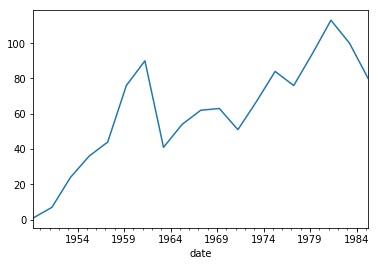

In [41]:
df2['text'].groupby(pd.TimeGrouper('24M')).count().plot(kind='line')
#also try this with D, W, M, 6M, 12M 

In [ ]:
#You can create new dataframes that only contain a slice of the data based on their date. 
#Change the names of the variables 'df1970-1971' and 'df1975-1979' and the way they are sliced'
df1970_1971 = df2['1970':'1971']
df1975_1979 = df2['1975':'1979']

<h2>Output data</h2>
<p>In the next part of this workshop, we will work with raw text data. For this reason, we will export only the text column of the dataframe as one larger text-file.</p>

In [43]:
#give the .txt file a name you prefer
#we leave out the index column and the headers and only select the column 'text'
#you can also change df into the name of the slice you defined in the previous step. For instance, df1970_1971.
df2['text'].to_csv("text_clean.txt", sep=' ', encoding='utf-8', index=False, header=False) 

In [ ]:
#we will also output the text that was not cleaned. Save this using a different output name
df['text'].to_csv("raw_text.txt", sep=' ', index=False, header=False) 